#**ASSIGNMENT 02**

# **Shimange PH (790282)**

# **Baloyi S  (1386169)**

# **Mawela V (1723950)**

# **Ndou SE (1905204)**


In [4]:
!pip install folium
!pip install geopandas 
!pip install geoplot 
!pip install utm 
!pip install colour
!pip install imageio 
!pip install geocoder
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import geoplot as gplt
import geocoder
import geoplot.crs as gcrs
import imageio
import hdbscan
import utm
from shapely.geometry import Point
import math
from ipywidgets import interact, interactive
import warnings
warnings.filterwarnings('ignore')
from colour import Color
import ipywidgets as widgets

import pathlib
import mapclassify as mc
import folium
from folium import plugins
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
from branca.element import Figure
from shapely.geometry import Polygon, Point
from folium.vector_layers import CircleMarker

In [6]:
#df = pd.read_csv("nyc_taxis.csv")
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import pandas as pd
df=pd.read_csv('/content/gdrive/MyDrive/COMS4060A/nyc_taxis.csv')

### 1. Data Cleaning

In [8]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [9]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing entries in the dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [11]:
df.shape

(1458644, 11)

### Trip duration

This is the shape of the dataset before cleaning.

In [12]:
df['trip_duration'].max() 

3526282

Above, we checked the maximum value for trip duration and noticed that the highest duration is over 3 million, which is a duration that is highly unlikely. 

In [13]:
duration = ((df.trip_duration < 60) | # < 1 min
 (df.trip_duration > 3600*2)) # > 2 hours
print('Outliers in trip duration: {:.2f} %'.format((df[duration].shape[0] / df.shape[0]) * 100))

Outliers in trip duration: 0.74 %


In [14]:
# Well generally a trip duration should not be more than a day, which is 86400 seconds.
print('Trip duration in seconds: {} to {}'.format(df.trip_duration.min(), df.trip_duration.max()))


Trip duration in seconds: 1 to 3526282


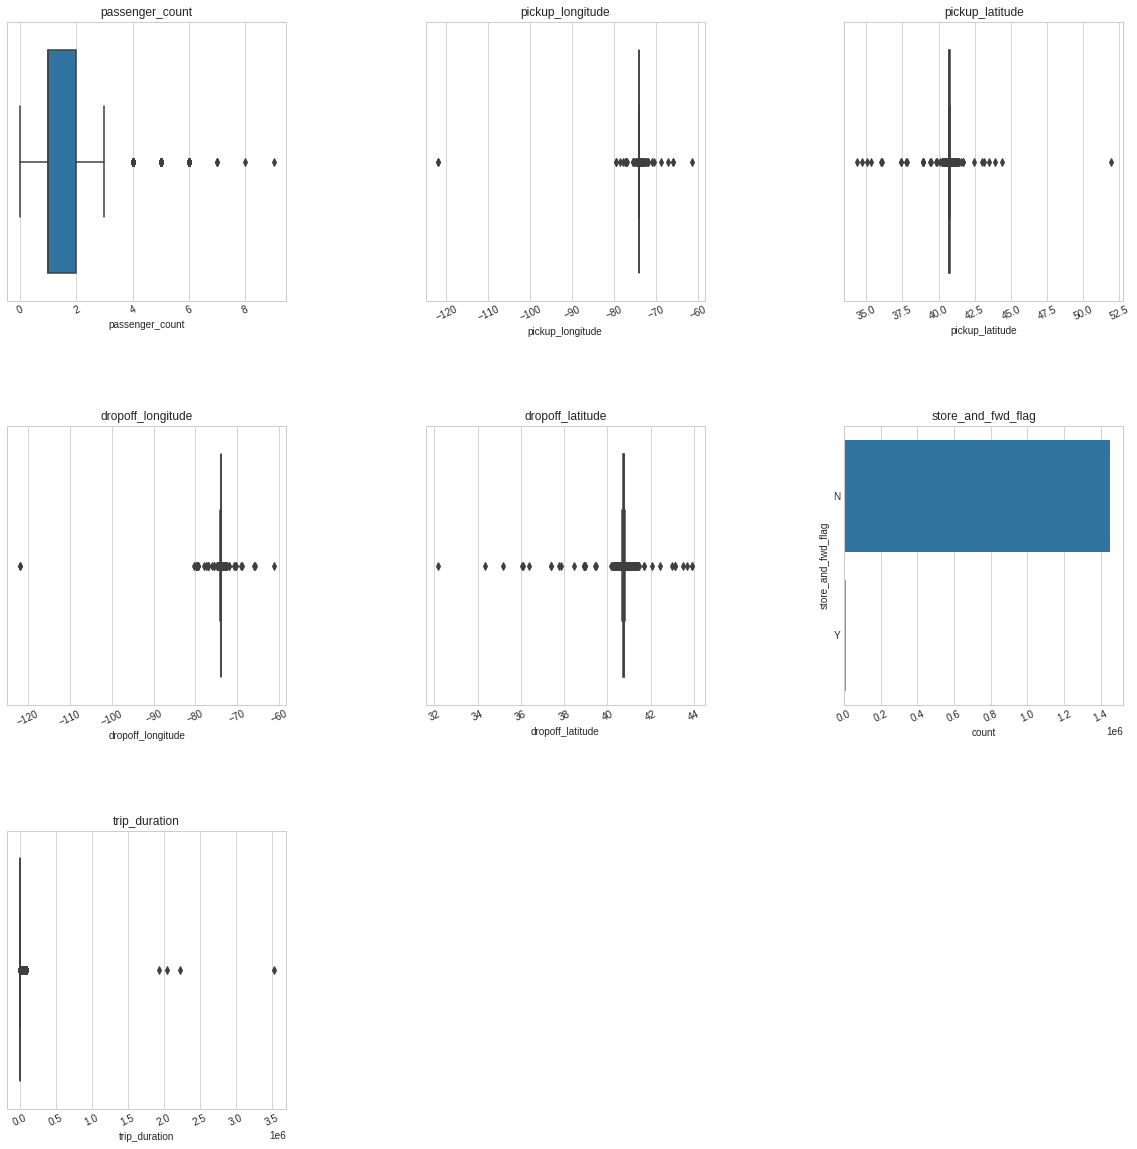

In [15]:
from pandas.io.formats.format import DataFrameRenderer
def plot_distribution(df, cols=9, width=25, height=15, hspace=0.2, wspace=0.5):
   plt.style.use('seaborn-whitegrid')
   fig = plt.figure(figsize=(width,height))
   fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
   rows = math.ceil(float(df.shape[1]) / cols)
   for i, column in enumerate(df.columns):
      ax = fig.add_subplot(rows, cols, i + 1)
      ax.set_title(column)
      if df.dtypes[column] == np.object:
        g = sns.countplot(y=column, data=df)
        substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
        g.set(yticklabels=substrings)
        plt.xticks(rotation=25)
      else:
          g = sns.boxplot(df[column])
          plt.xticks(rotation=25)
cols_to_plot = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag','trip_duration']
plot_distribution(df[cols_to_plot], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

In [16]:
df = df[~duration]
df.trip_duration = df.trip_duration.astype(np.uint16)

In [17]:
print('Trip duration in seconds: {} to {}'.format(df.trip_duration.min(), df.trip_duration.max())) # range after cleaning

Trip duration in seconds: 60 to 7191


In [18]:
len(df.trip_duration)

1447796

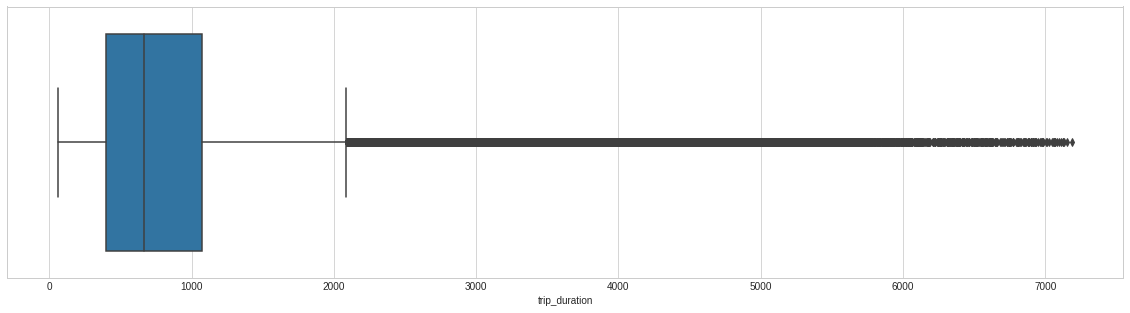

In [19]:
plt.figure(figsize=(20,5))
sns.boxplot(df.trip_duration)
plt.show()

### Passengers

In [20]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
df.passenger_count.value_counts()

1    1025323
2     209086
5      77569
3      59545
6      48031
4      28223
0         17
9          1
8          1
Name: passenger_count, dtype: int64

In [21]:
# Passenger Count Outliers
df['passenger_count'].max() 

9

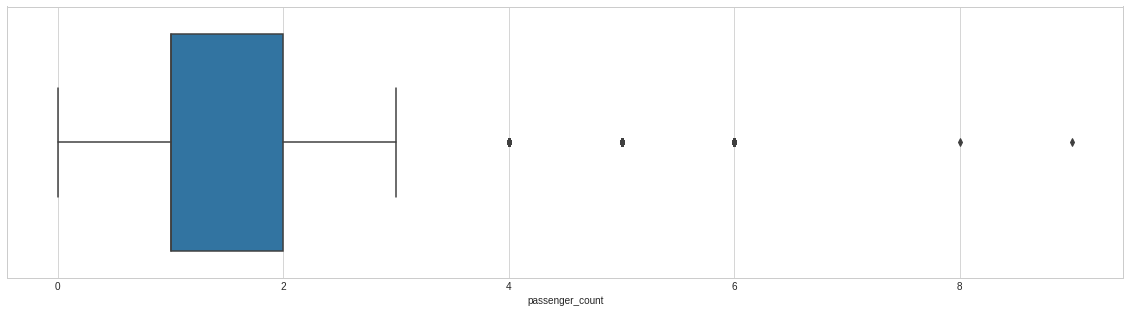

In [22]:
plt.figure(figsize=(20,5))
sns.boxplot(df.passenger_count)
plt.show()

There are some trips with 0 passenger count. Few trips consisted of even 7, 8 or 9 passengers. Clear outliers and pointers to data inconsistency. Most of the trips consist of either 1 or 2 passengers.

With the passenger count value being entered by the driver and assuming that trips are not possible without passengers, it is evident that the driver might have forgotten to enter the value for the trips with 0 passenger count.

We then further analysed passenger count distribution to make it consistent for further analysis.

In [23]:
df.passenger_count.describe()

count   1447796.00
mean          1.67
std           1.31
min           0.00
25%           1.00
50%           1.00
75%           2.00
max           9.00
Name: passenger_count, dtype: float64

As per above details. Mean median and mode are all approximately equal to 1. So we will replace 0 passenger count with 1.

In [24]:
df['passenger_count'] = df.passenger_count.map(lambda x: 1 if x == 0 else x)

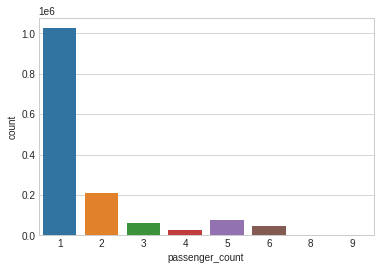

In [25]:
sns.countplot(df.passenger_count)
plt.show()

In [26]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
df.passenger_count.value_counts()

1    1025340
2     209086
5      77569
3      59545
6      48031
4      28223
9          1
8          1
Name: passenger_count, dtype: int64

In [27]:
len(df)

1447796

### 2. Feature generation

gdf = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.Longitude, df.Latitude))

In [28]:
df['pickup_points'] = gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude)
df['dropoff_points'] = gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude)

In [29]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_points,dropoff_points
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,POINT (-73.98215 40.76794),POINT (-73.96463 40.76560)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,POINT (-73.98042 40.73856),POINT (-73.99948 40.73115)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,POINT (-73.97903 40.76394),POINT (-74.00533 40.71009)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,POINT (-74.01004 40.71997),POINT (-74.01227 40.70672)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,POINT (-73.97305 40.79321),POINT (-73.97292 40.78252)


- Trip Distance 

In [30]:
crs = 'EPSG:4326' # {'init':'EPSG:4326'} deprecated, try '<init>:<EPSG:4326>' 
geo_1 = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
geo_2 = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
geo_df_pickup = gpd.GeoDataFrame(df[['pickup_longitude', 'pickup_latitude']], geometry = geo_1, crs = crs)
geo_df_dropoff = gpd.GeoDataFrame(df[['dropoff_longitude', 'dropoff_latitude']], geometry = geo_2, crs = crs)

points_df2 = points_df.shift():  shift the dataframe by 1 to align point1 with point2. 
We chose 2263 EPSG for New York

In [31]:
geo_df_pickup = geo_df_pickup.to_crs('EPSG:2263')
geo_df_dropoff = geo_df_dropoff.to_crs('EPSG:2263')
df['distance'] = geo_df_pickup.distance(geo_df_dropoff) # Distance in meters.
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_points,dropoff_points,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,POINT (-73.98215 40.76794),POINT (-73.96463 40.76560),4928.36
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,POINT (-73.98042 40.73856),POINT (-73.99948 40.73115),5933.89
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,POINT (-73.97903 40.76394),POINT (-74.00533 40.71009),20930.62
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,POINT (-74.01004 40.71997),POINT (-74.01227 40.70672),4867.54
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,POINT (-73.97305 40.79321),POINT (-73.97292 40.78252),3894.46


 - Day of the week

In [32]:
df_date = pd.to_datetime(df['pickup_datetime'])
df['dayOfWeek'] = df_date.dt.day_name()

In [33]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_points,dropoff_points,distance,dayOfWeek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,POINT (-73.98215 40.76794),POINT (-73.96463 40.76560),4928.36,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,POINT (-73.98042 40.73856),POINT (-73.99948 40.73115),5933.89,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,POINT (-73.97903 40.76394),POINT (-74.00533 40.71009),20930.62,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,POINT (-74.01004 40.71997),POINT (-74.01227 40.70672),4867.54,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,POINT (-73.97305 40.79321),POINT (-73.97292 40.78252),3894.46,Saturday


- Average Speed of trip

In [34]:
## Speed = Distance (m) / Time (s) m/s
df['Avg_speed'] = df['distance'] / df['trip_duration'] 

In [35]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_points,dropoff_points,distance,dayOfWeek,Avg_speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,POINT (-73.98215 40.76794),POINT (-73.96463 40.76560),4928.36,Monday,10.83
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,POINT (-73.98042 40.73856),POINT (-73.99948 40.73115),5933.89,Sunday,8.95
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,POINT (-73.97903 40.76394),POINT (-74.00533 40.71009),20930.62,Tuesday,9.85
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,POINT (-74.01004 40.71997),POINT (-74.01227 40.70672),4867.54,Wednesday,11.35
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,POINT (-73.97305 40.79321),POINT (-73.97292 40.78252),3894.46,Saturday,8.95


### 3. Time-based 

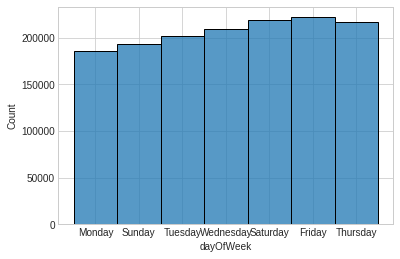

In [36]:
# 3.1
sns.histplot(data=df, x= 'dayOfWeek')
plt.show() 

The graph above shows that Friday is the most popular day of the week. 

In [37]:
# 3.2
df['hour'] = df_date.dt.hour

for i, x in enumerate(df['dayOfWeek'].unique()):
 print(x, ": Popular Hour: ", int(df[df['dayOfWeek'] == x]['hour'].mode()))

Monday : Popular Hour:  18
Sunday : Popular Hour:  0
Tuesday : Popular Hour:  18
Wednesday : Popular Hour:  19
Saturday : Popular Hour:  23
Friday : Popular Hour:  19
Thursday : Popular Hour:  21


sns.violinplot(data=df, x="dayOfWeek", y="hour", 
 split=True, inner="quart", linewidth=1,)
sns.despine(left=True)
plt.show()

The Output above shows the most popular hour for each day of the week and the violin plot above shows the distribution of each hour during each day of the week. 
For Monday and Tuesday, the most popular hour (18:00) might be due to the end of business day whereby most people are traveling back home from work.
For Wednesday and Friday, the most popular hour (19:00) is also most probably due to end of business day rush.
For Thursday, the most popular hour (21:00), could be due to the assumption that rush hour time usually ranges from 6pm to 9pm and therefore, the most popular time for thursday in this case falls within this period.
The popular hours for Saturday (23:00) and Sunday (00:00) are during night time. This could be due to people going out during weekend as compared to weekdays and therefore around these late hours, it is very common that people request for cab to go home.  

3.3
Compared to the mornings of the weekdays, people frequently use taxis in the early morning hours on weekends.
The most common times have been from 18:00 to 21:00, which indicates a potential after-hours or a general end to the business day on weekdays. The use of taxis in the early hours on weekends can indicate that people use them after party hours.

In [38]:
#3.4 
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [39]:
df['month'] = df_date.dt.month
df['day'] = df_date.dt.day

In [40]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_points,dropoff_points,distance,dayOfWeek,Avg_speed,hour,month,day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,POINT (-73.98215 40.76794),POINT (-73.96463 40.76560),4928.36,Monday,10.83,17,3,14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,POINT (-73.98042 40.73856),POINT (-73.99948 40.73115),5933.89,Sunday,8.95,0,6,12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,POINT (-73.97903 40.76394),POINT (-74.00533 40.71009),20930.62,Tuesday,9.85,11,1,19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,POINT (-74.01004 40.71997),POINT (-74.01227 40.70672),4867.54,Wednesday,11.35,19,4,6
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,POINT (-73.97305 40.79321),POINT (-73.97292 40.78252),3894.46,Saturday,8.95,13,3,26


In [41]:
MLKJr = df[(df['month'] == 1) & (df['day'] == 18)]
val = df[(df['month'] == 2) & (df['day'] == 14)]
st_pat = df[(df['month'] == 3) & (df['day'] == 17)]
easter = df[(df['month'] == 3) & (df['day'] == 27)]
memorial = df[(df['month'] == 5) & (df['day'] == 30)]

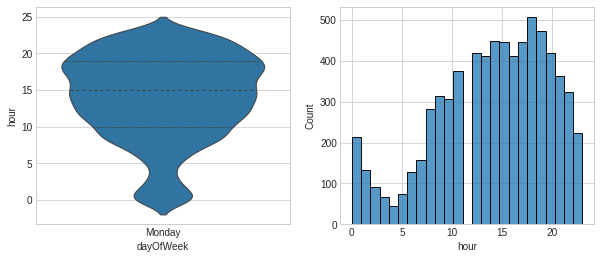

In [42]:
# Martin Luther King Day (MLKJr)
f, axes = plt.subplots(1,2, figsize=(10, 4))
sns.violinplot(data=MLKJr, x="dayOfWeek", y="hour", split=True, inner="quart", linewidth=1, ax=axes[0])
sns.histplot(data=MLKJr, x= "hour", ax=axes[1])
plt.show()

On Martin Luther king Day, it is evident that taxis are in more demand in the latter hours. Operations start to pick up about 8:00 am, with 18:00 being the busiest.

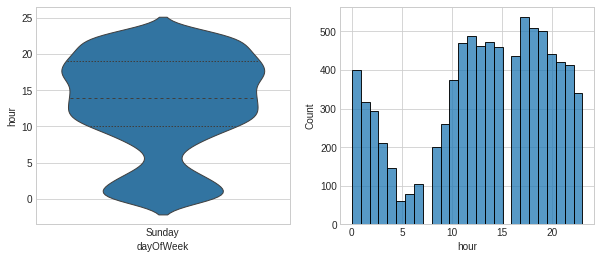

In [43]:
# Valentine's Day
f, axes = plt.subplots(1,2, figsize=(10, 4))
sns.violinplot(data=val, x="dayOfWeek", y="hour", split=True, inner="quart", linewidth=1, ax=axes[0])
sns.histplot(data=val, x= "hour", ax=axes[1])
plt.show()

On Valentine's day, taxis often run more frequently in the morning and into the evening. This steep surge begins at 10:00 am and lasts all day. The peak period is at roughly 17:00.

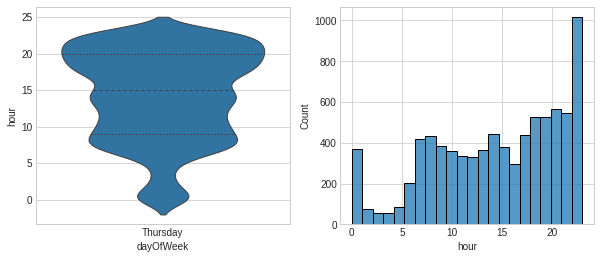

In [44]:
# St Patrick's Day
f, axes = plt.subplots(1,2, figsize=(10, 4))
sns.violinplot(data=st_pat, x="dayOfWeek", y="hour", split=True, inner="quart", linewidth=1, ax=axes[0])
sns.histplot(data=st_pat, x= "hour", ax=axes[1])
plt.show()

On St. Patrick's Day, it is evident that taxis are in more demand in the latter hours. Operations start to pick up about 7:00 am, with 22:00 being the busiest.

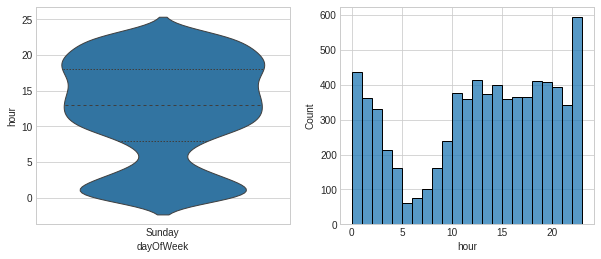

In [45]:
# Easter 
f, axes = plt.subplots(1,2, figsize=(10, 4))
sns.violinplot(data=easter, x="dayOfWeek", y="hour", split=True, inner="quart", linewidth=1, ax=axes[0])
sns.histplot(data=easter, x= "hour", ax=axes[1])
plt.show()


During Easter, taxis typically run continuously, but mostly after 10:00 a.m. Around Midnight, it is most popular.

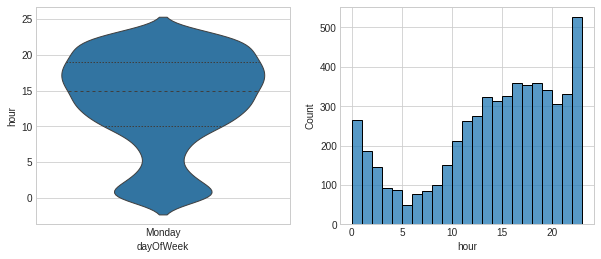

In [46]:
# Memorial Day
f, axes = plt.subplots(1,2, figsize=(10, 4))
sns.violinplot(data=memorial, x="dayOfWeek", y="hour", split=True, inner="quart", linewidth=1, ax=axes[0])
sns.histplot(data=memorial, x= "hour", ax=axes[1])
plt.show()

On Memorial Day, taxis often run more frequently in the morning and into the evening. This steep surge begins at 10:00 am and lasts all day. The peak period is at roughly 22:00.

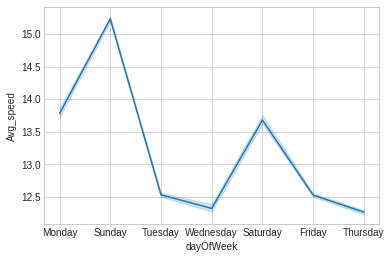

In [47]:
#3.5 
sns.lineplot(data=df, x="dayOfWeek", y="Avg_speed")
plt.show()

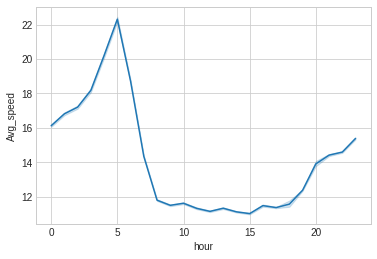

In [48]:
sns.lineplot(data=df, x="hour", y="Avg_speed")
plt.show()

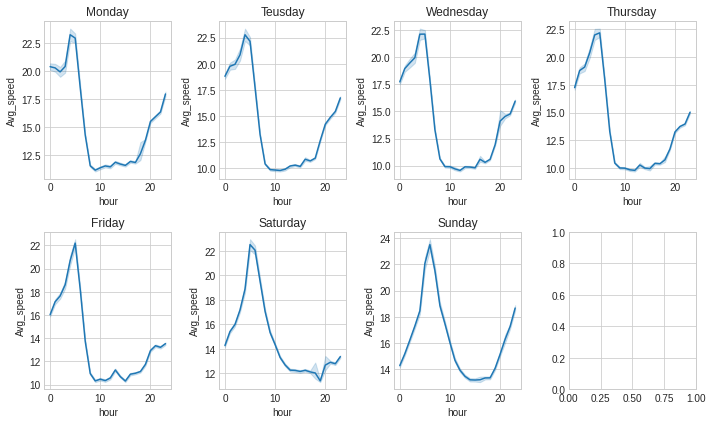

In [49]:
# Checking each day of the week individually
f, axes = plt.subplots(2,4, figsize=(10, 6))
sns.lineplot(data=df[df['dayOfWeek'] == 'Monday'], x="hour", y="Avg_speed" , ax=axes[0,0]).set_title('Monday')
sns.lineplot(data=df[df['dayOfWeek'] == 'Tuesday'], x="hour", y="Avg_speed" , ax=axes[0,1]).set_title('Teusday')
sns.lineplot(data=df[df['dayOfWeek'] == 'Wednesday'], x="hour", y="Avg_speed" , ax=axes[0,2]).set_title('Wednesday')
sns.lineplot(data=df[df['dayOfWeek'] == 'Thursday'], x="hour", y="Avg_speed" , ax=axes[0,3]).set_title('Thursday')
sns.lineplot(data=df[df['dayOfWeek'] == 'Friday'], x="hour", y="Avg_speed" , ax=axes[1,0]).set_title('Friday')
sns.lineplot(data=df[df['dayOfWeek'] == 'Saturday'], x="hour", y="Avg_speed" , ax=axes[1,1]).set_title('Saturday')
sns.lineplot(data=df[df['dayOfWeek'] == 'Sunday'], x="hour", y="Avg_speed" , ax=axes[1,2]).set_title('Sunday')
plt.tight_layout()
plt.show()

Trips are quicker at 5 a.m., as seen in the graphs above, before dropping down sharply until 16:00., when they resume at a higher rate than before. 

### 4. Location Clusters 
#### 4.1 Heatmaps 

1. Weekdays and weekends 

In [50]:
# weekdays and weekends
df_weekdays = df[(df['dayOfWeek'] != 'Saturday') & (df['dayOfWeek'] != 'Sunday')]
df_weekends = df[(df['dayOfWeek'] == 'Saturday') | (df['dayOfWeek'] == 'Sunday')]


In [51]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=8):
 fig = Figure(width=900,height=600)
 base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
 fig.add_child(base_map)
 return base_map


In [52]:
base_map = generateBaseMap()
base_map

In [53]:
df_weekdays['count'] = 1
df_weekends['count'] = 1

In [54]:
# weekdays 
base_map = generateBaseMap()
HeatMap(data=df_weekdays[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

In [ ]:
# Weekends
base_map = generateBaseMap()
HeatMap(data=df_weekends[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map


Weekdays vs Weekends heatmaps: Weekdays have greater concentration than weekends

2. Morning and evening 

In [ ]:
# morning and evening (7-10 am)(16-19 pm)
df_mornings = df[(df['hour'] == 7) | (df['hour'] == 8) | (df['hour'] == 9) | (df['hour'] == 10)]
df_evenings = df[(df['hour'] == 16) | (df['hour'] == 17) | (df['hour'] == 18) | (df['hour'] == 19)]

In [ ]:
df_mornings['count'] = 1
df_evenings['count'] = 1

In [ ]:
# Mornings
base_map = generateBaseMap()
HeatMap(data=df_mornings[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map


In [ ]:
# Evenings
base_map = generateBaseMap()
HeatMap(data=df_evenings[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

Mornings vs Evenings heatmaps: Evenings have a greater level of focus than do the evenings 

In general, New York City has a disproportionately high concentration of pickup locations in contrast to the random distribution of other pickups in the neighborhood

In [ ]:
# Mornings, Plotting each hour of the Morning (7,8,9,10) am
df_hour_list = []
for hour in df_mornings.hour.sort_values().unique():
 df_hour_list.append(df_mornings.loc[df_mornings.hour == hour, ['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist())


In [ ]:
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
folium.TileLayer('cartodbpositron').add_to(base_map)
base_map


In [ ]:
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
folium.TileLayer('cartodbpositron').add_to(base_map)
base_map


In [ ]:
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
folium.TileLayer('cartodbpositron').add_to(base_map)
base_map


### 4.2 Hotspots 

In [70]:
#  23:00 on a Friday evening to 02:00 on a Saturday morning,
selection_1 = df[((df['dayOfWeek'] == 'Saturday') | (df['dayOfWeek'] == 'Friday')) & (df['hour'] == 23) | (df['hour']==0) | (df['hour']==1) | (df['hour']==2)]

In [72]:
# 17:00 and 20:00 on a Thursday
selection_2 = df[(df['dayOfWeek'] == 'Thursday') & ((df['hour'] == 17) | (df['hour'] == 18) | (df['hour'] == 19) | (df['hour'] == 20))]


In [74]:
loc_ini = selection_1[['pickup_latitude', 'pickup_longitude']].to_numpy()
loc_end = selection_1[['dropoff_latitude', 'dropoff_longitude']].to_numpy()
locations = np.vstack((loc_ini, loc_end))


. function to fit an HDBSCAN clusterer object. The fit_utm_clusterer function fits an HDBSCAN model using utm - Universal Transverse Mercator coordinate system

In [76]:
def fit_utm_clusterer(locations, min_cluster_size=20, min_samples=15, cluster_selection_epsilon = 49): #min_cluster_size = 15?, #cluster_selection_epsilon (distance)= 50 or 100?
    xyzz = [utm.from_latlon(ll[0], ll[1]) for ll in locations]
    pts = [[p[0], p[1]] for p in xyzz]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                             min_samples=min_samples,
                             cluster_selection_epsilon=cluster_selection_epsilon,
                             metric='euclidean')
    clusterer.fit(pts)
    return clusterer

In [78]:
clusterer = fit_utm_clusterer(locations)

In [80]:
unique_clusters = np.unique(clusterer.labels_)[1:]
print("The initial number of clusters is: {0}".format(unique_clusters.shape[0]))

The initial number of clusters is: 118


In [82]:
def show_cluster_map(cluster_id):
    blue = Color("blue")
    red = Color("red")
    color_range = list(blue.range_to(red, 10))
    
    # base_map = generateBaseMap() # try base_map instead of map_ 
    map_ = folium.Map(width=900,height=500, prefer_canvas=True, tiles='CartoDB positron')
    
    clusters = clusterer.labels_
    outlier_scores = clusterer.outlier_scores_
    
    points = locations[clusters == cluster_id]
    scores = outlier_scores[clusters == cluster_id]


    for i in range(points.shape[0]):
        point = points[i]
        color = color_range[int(scores[i] * 10)]
        CircleMarker([point[0],point[1]], radius=1, color = color.hex, tooltip = "{:.2f}".format(scores[i])).add_to(map_)

    min_lat, max_lat = points[:, 0].min(), points[:, 0].max()
    min_lon, max_lon = points[:, 1].min(), points[:, 1].max()
    map_.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

    return map_


. Friday night/Saturday midnight (0) Hotspots

In [84]:
ii = interact(show_cluster_map, cluster_id = widgets.IntText(min=0, max= clusterer.labels_.max(), step=1, value=0))


interactive(children=(IntText(value=0, description='cluster_id'), Output()), _dom_classes=('widget-interact',)…

Since there should be 15 pickups in the location in order to classify as a hotspot, the parameter minimum sample size (min_samples) is set to 15.
A minimum cluster size of 20 is chosen as well. slightly bigger than the min_samples to capture a little more detail within clusters.
cluster_selection_epsilon(distances between clusters) = 49 So that any point above 49 meters is not merged into the current cluster.
Overall, with the parameters chosen, a total of 421 hotspot locations were found around midnight on friday and Saturday.

In [86]:
loc_ini = selection_2[['pickup_latitude', 'pickup_longitude']].to_numpy()
loc_end = selection_2[['dropoff_latitude', 'dropoff_longitude']].to_numpy()
locations = np.vstack((loc_ini, loc_end))


In [88]:
def fit_utm_clusterer(locations,min_cluster_size=20, min_samples=15, cluster_selection_epsilon=49): #min_cluster_size = 15?, #cluster_selection_epsilon (distance)= 50 or 100?
    xyzz = [utm.from_latlon(ll[0], ll[1]) for ll in locations]
    pts = [[p[0], p[1]] for p in xyzz]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
    min_samples=min_samples,
    cluster_selection_epsilon=cluster_selection_epsilon,
    metric='euclidean')
    clusterer.fit(pts)
    return clusterer


In [90]:
clusterer = fit_utm_clusterer(locations)

In [92]:
unique_clusters = np.unique(clusterer.labels_)[1:]
print("The initial number of clusters is: {0}".format(unique_clusters.shape[0]))


The initial number of clusters is: 118


In [94]:
def show_cluster_map(cluster_id):
    blue = Color("blue")
    red = Color("red")
    color_range = list(blue.range_to(red, 10))

    # base_map = generateBaseMap() # try base_map instead of map_ 
    map_ = folium.Map(width=900,height=500,prefer_canvas=True, tiles='CartoDB positron')

    clusters = clusterer.labels_
    outlier_scores = clusterer.outlier_scores_

    points = locations[clusters == cluster_id]
    scores = outlier_scores[clusters == cluster_id]


    for i in range(points.shape[0]):
        point = points[i]
        color = color_range[int(scores[i] * 10)]
        CircleMarker([point[0],point[1]], radius=1, color = color.hex, tooltip = "{:.2f}".format(scores[i])).add_to(map_)

    min_lat, max_lat = points[:, 0].min(), points[:, 0].max()
    min_lon, max_lon = points[:, 1].min(), points[:, 1].max()
    map_.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

    return map_


In [96]:
ii = interact(show_cluster_map, cluster_id = widgets.IntText(min=0, max= clusterer.labels_.max(), step=1, value=0))

interactive(children=(IntText(value=0, description='cluster_id'), Output()), _dom_classes=('widget-interact',)…

In this case over 119 hotspot locations were found from a period of 17-20 pm on a Thursday afternoon. Using the parameters.
minimum cluster size (min_samples) is set to 15
A minimum cluster size of 20
cluster_selection_epsilon(distances between clusters) = 49

### 5. Airports 

.  JFK Airport: (40.647929, -73.777813)
    
.  Empire State Building: (40.756724, -73.983806)  

.   Newark Airport: (40.689442, -74.173242)     

In [117]:
# lat/lon data is lon/lat
jfk = [40.644167, -73.782222]
esb = [40.748817, -73.985428]
nwa = [40.689722, -74.174462]


In [118]:
sample = df[(df.trip_duration >= 2760) & (df.trip_duration <= 3070)]
sample


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_points,dropoff_points,distance,dayOfWeek,Avg_speed,hour,month,day
98,id2102594,1,2016-03-30 16:14:29,2016-03-30 17:01:33,1,-73.79,40.64,-73.97,40.69,N,2824,POINT (-73.78984 40.64356),POINT (-73.97066 40.68728),52633.21,Wednesday,18.64,16,3,30
198,id3942917,1,2016-04-29 14:18:39,2016-04-29 15:05:36,4,-73.86,40.77,-73.99,40.75,N,2817,POINT (-73.86278 40.76931),POINT (-73.98613 40.74858),34997.80,Friday,12.42,14,4,29
488,id1506453,1,2016-06-16 10:23:25,2016-06-16 11:10:36,1,-73.99,40.76,-74.00,40.72,N,2831,POINT (-73.99082 40.75575),POINT (-73.99753 40.72243),12280.08,Thursday,4.34,10,6,16
839,id1437834,2,2016-05-03 10:28:30,2016-05-03 11:17:57,2,-73.87,40.77,-74.00,40.76,N,2967,POINT (-73.87097 40.77382),POINT (-74.00072 40.75756),36425.34,Tuesday,12.28,10,5,3
1008,id3039752,1,2016-04-14 15:08:54,2016-04-14 15:56:02,1,-73.99,40.76,-73.87,40.77,N,2828,POINT (-73.98738 40.76071),POINT (-73.87199 40.77425),32342.65,Thursday,11.44,15,4,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458263,id3934738,2,2016-06-09 08:37:03,2016-06-09 09:27:50,5,-73.87,40.77,-74.00,40.74,N,3047,POINT (-73.87092 40.77375),POINT (-73.99850 40.73724),37765.85,Thursday,12.39,8,6,9
1458310,id1325943,1,2016-05-25 15:08:13,2016-05-25 15:58:24,1,-73.99,40.72,-73.96,40.78,N,3011,POINT (-73.99357 40.72450),POINT (-73.95574 40.77960),22645.64,Wednesday,7.52,15,5,25
1458333,id1758713,2,2016-04-17 14:56:46,2016-04-17 15:46:59,1,-73.78,40.64,-73.97,40.75,N,3013,POINT (-73.78272 40.64497),POINT (-73.97481 40.75066),65725.16,Sunday,21.81,14,4,17
1458363,id3404858,2,2016-05-18 12:39:49,2016-05-18 13:29:33,2,-73.98,40.73,-73.99,40.76,N,2984,POINT (-73.97551 40.73307),POINT (-73.99024 40.76244),11452.41,Wednesday,3.84,12,5,18


In [119]:
# reverse geocode the pickup and dropoff locations to get the address
def reverse_geo_pick(x):
    p = geocoder.osm([x.pickup_latitude, x.pickup_longitude], method ='reverse').json
    if p:
        return p.get('address')
    else:
        return 'NA'

    def reverse_geo_drop(x):
        d = geocoder.osm([x.dropoff_latitude, x.dropoff_longitude], method ='reverse').json
    if d:
        return d.get('address')
    else:
        return 'NA'

In [120]:
#sample['pickup_address'] = sample[['pickup_latitude', 'pickup_longitude']].apply(reverse_geo_pick, axis = 1)
#sample['dropoff_address'] = sample[['dropoff_latitude', 'dropoff_longitude']].apply(reverse_geo_drop, axis = 1)

In [121]:
sample

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_points,dropoff_points,distance,dayOfWeek,Avg_speed,hour,month,day
98,id2102594,1,2016-03-30 16:14:29,2016-03-30 17:01:33,1,-73.79,40.64,-73.97,40.69,N,2824,POINT (-73.78984 40.64356),POINT (-73.97066 40.68728),52633.21,Wednesday,18.64,16,3,30
198,id3942917,1,2016-04-29 14:18:39,2016-04-29 15:05:36,4,-73.86,40.77,-73.99,40.75,N,2817,POINT (-73.86278 40.76931),POINT (-73.98613 40.74858),34997.80,Friday,12.42,14,4,29
488,id1506453,1,2016-06-16 10:23:25,2016-06-16 11:10:36,1,-73.99,40.76,-74.00,40.72,N,2831,POINT (-73.99082 40.75575),POINT (-73.99753 40.72243),12280.08,Thursday,4.34,10,6,16
839,id1437834,2,2016-05-03 10:28:30,2016-05-03 11:17:57,2,-73.87,40.77,-74.00,40.76,N,2967,POINT (-73.87097 40.77382),POINT (-74.00072 40.75756),36425.34,Tuesday,12.28,10,5,3
1008,id3039752,1,2016-04-14 15:08:54,2016-04-14 15:56:02,1,-73.99,40.76,-73.87,40.77,N,2828,POINT (-73.98738 40.76071),POINT (-73.87199 40.77425),32342.65,Thursday,11.44,15,4,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458263,id3934738,2,2016-06-09 08:37:03,2016-06-09 09:27:50,5,-73.87,40.77,-74.00,40.74,N,3047,POINT (-73.87092 40.77375),POINT (-73.99850 40.73724),37765.85,Thursday,12.39,8,6,9
1458310,id1325943,1,2016-05-25 15:08:13,2016-05-25 15:58:24,1,-73.99,40.72,-73.96,40.78,N,3011,POINT (-73.99357 40.72450),POINT (-73.95574 40.77960),22645.64,Wednesday,7.52,15,5,25
1458333,id1758713,2,2016-04-17 14:56:46,2016-04-17 15:46:59,1,-73.78,40.64,-73.97,40.75,N,3013,POINT (-73.78272 40.64497),POINT (-73.97481 40.75066),65725.16,Sunday,21.81,14,4,17
1458363,id3404858,2,2016-05-18 12:39:49,2016-05-18 13:29:33,2,-73.98,40.73,-73.99,40.76,N,2984,POINT (-73.97551 40.73307),POINT (-73.99024 40.76244),11452.41,Wednesday,3.84,12,5,18


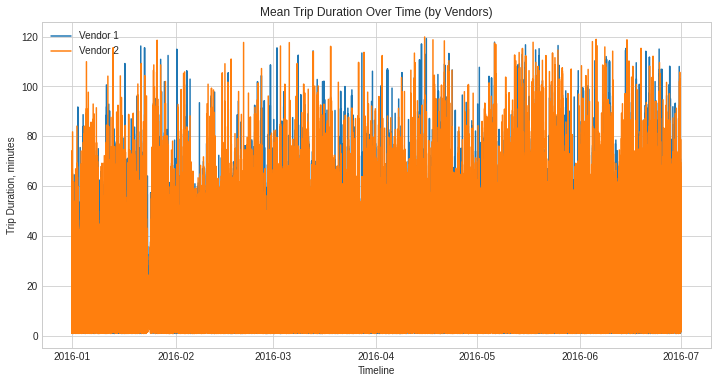

In [122]:
data = pd.crosstab(index=df_date, 
                   columns=df.vendor_id, 
                   values=df.trip_duration/60, 
                   aggfunc='mean')
plt.figure(figsize=(12,6))
plt.title('Mean Trip Duration Over Time (by Vendors)')
plt.ylabel('Trip Duration, minutes') ; plt.xlabel('Timeline')
plt.plot(data)
plt.legend(['Vendor 1', 'Vendor 2'])
plt.show()

In [123]:
 #df['pickup_address'] = df[['pickup_latitude', 'pickup_longitude']].apply(reverse_geo_pick, axis = 1)


In [124]:
sub= df[['pickup_datetime', 'trip_duration']].copy()
sub['date'] = pd.to_datetime(sub['pickup_datetime'], format='%Y-%m-%d')
sub.set_index(sub['date'], inplace=True)

In [125]:
sub.head()

,pickup_datetime,trip_duration,date
date,,,
2016-03-14 17:24:55,2016-03-14 17:24:55,455,2016-03-14 17:24:55
2016-06-12 00:43:35,2016-06-12 00:43:35,663,2016-06-12 00:43:35
2016-01-19 11:35:24,2016-01-19 11:35:24,2124,2016-01-19 11:35:24
2016-04-06 19:32:31,2016-04-06 19:32:31,429,2016-04-06 19:32:31
2016-03-26 13:30:55,2016-03-26 13:30:55,435,2016-03-26 13:30:55


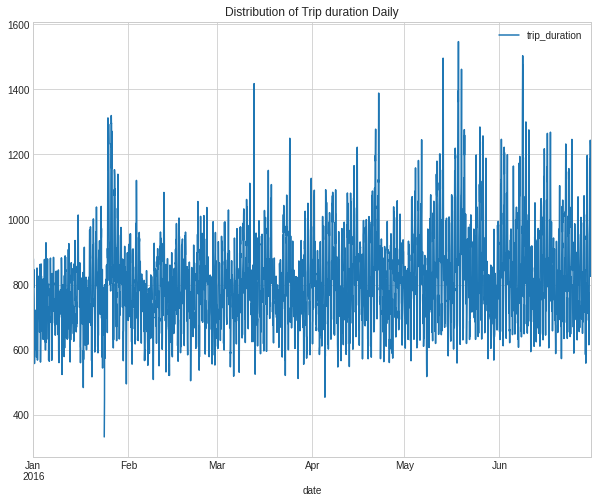

In [126]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 8)
sub.resample('H').mean().plot(ax=ax) # Daily
plt.title("Distribution of Trip duration Daily")
plt.show()

In [127]:
#Empire state Building to John F Kennedy
base_map = generateBaseMap(default_zoom_start=11)
folium.PolyLine(locations=[esb, jfk], color= 'blue').add_to(base_map)
base_map

In [128]:
# Empire State Building to Newwark Airport 
base_map = generateBaseMap(default_zoom_start=11)
folium.PolyLine(locations=[esb, nwa], color= 'blue').add_to(base_map)
base_map


 ### 6. **Baroughs** 

1. Using this shapefile find the neighbourhoods for the trip start and end locations (try geopandas,
shapely, or fiona, for example)

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [131]:
# loadind shapefile
df_2 = gpd.read_file("/content/drive/MyDrive/nynta2010_22a/nynta2010_22a")
df_2.head()


,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,4,Queens,081,QN51,Murray Hill,33266.90,52488277.45,"POLYGON ((1038593.459 221913.355, 1039369.281 ..."
1,4,Queens,081,QN27,East Elmhurst,19816.71,19726845.73,"POLYGON ((1022728.275 217530.808, 1023052.644 ..."
2,4,Queens,081,QN41,Fresh Meadows-Utopia,22106.43,27774853.55,"POLYGON ((1045896.171 205383.934, 1045643.832 ..."
3,4,Queens,081,QN08,St. Albans,45401.32,77412747.89,"POLYGON ((1052996.114 196307.361, 1053081.596 ..."
4,3,Brooklyn,047,BK69,Clinton Hill,23971.47,20528197.03,"POLYGON ((997183.310 187255.551, 997207.887 18..."


In [132]:
 #Boroughs
df_2.BoroName.unique()
# 

array(['Queens', 'Brooklyn', 'Bronx', 'Staten Island', 'Manhattan'],
      dtype=object)

In [133]:
 #Neighbourhoods
df_2.NTAName.unique()

array(['Murray Hill', 'East Elmhurst', 'Fresh Meadows-Utopia',
       'St. Albans', 'Clinton Hill', 'Gravesend', 'Ocean Parkway South',
       'Van Cortlandt Village', 'South Ozone Park', 'Windsor Terrace',
       'Canarsie', 'Rossville-Woodrow', 'Upper West Side', 'Norwood',
       'Bedford Park-Fordham North', 'Mount Hope', 'North Corona',
       'West Brighton', 'Rego Park', 'Whitestone', 'Ozone Park',
       'Springfield Gardens South-Brookville', 'Fort Greene',
       'Starrett City', 'Gramercy', 'Ocean Hill',
       'Pomonok-Flushing Heights-Hillcrest', 'East Flushing',
       'Kingsbridge Heights', 'University Heights-Morris Heights',
       'Williamsburg', 'Madison', 'South Jamaica', 'Erasmus',
       'Rikers Island', 'Hollis', 'Rosedale', 'Richmond Hill',
       'Auburndale', 'Jamaica Estates-Holliswood', 'Jamaica', 'Corona',
       'Astoria', 'Bushwick North', 'Ridgewood', 'Elmhurst-Maspeth',
       'Stuyvesant Heights', 'East Tremont', 'East Williamsburg',
       'Midtown-Mi

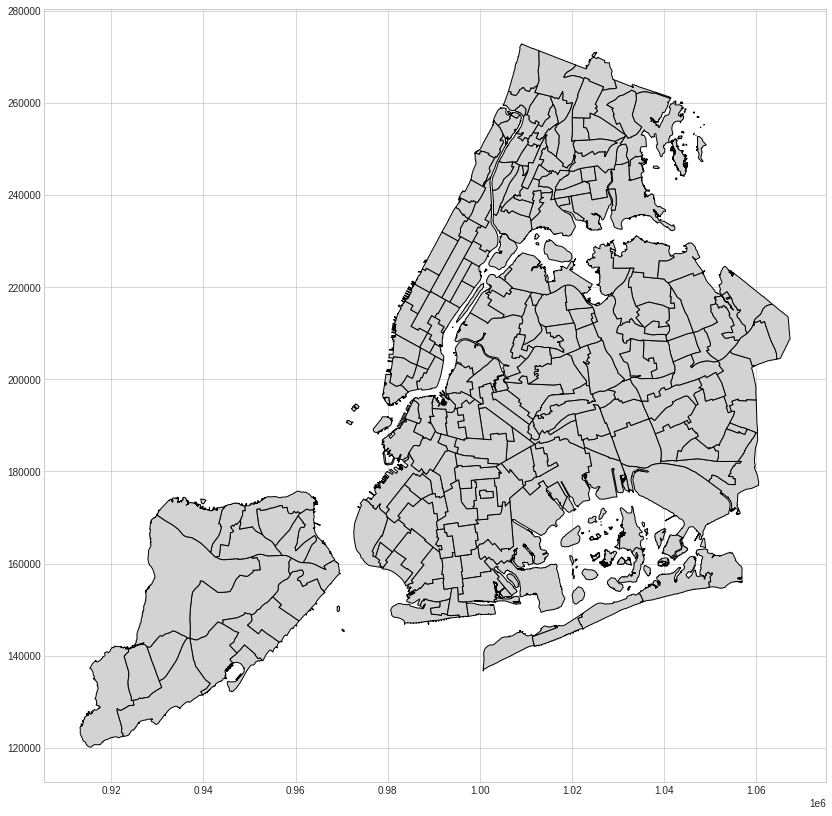

In [134]:
fig, ax = plt.subplots(figsize = (14,16))
df_2.plot(ax= ax, color='lightgrey', edgecolor='black')
plt.show()

In [168]:
gdf_pick = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude))

In [169]:
 #removing outliers that fall outside the boroughs
gdf_pick = gdf_pick[(gdf_pick['pickup_longitude'] > -74.3) & (gdf_pick['pickup_longitude'] < -73.7)]
gdf_pick = gdf_pick[(gdf_pick['pickup_latitude'] < 40.95) & (gdf_pick['pickup_latitude'] > 40.5)]


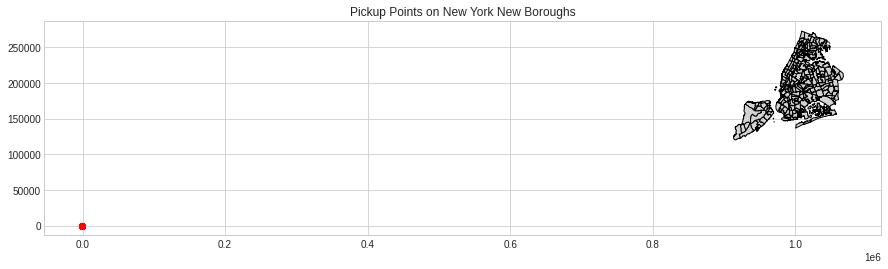

In [170]:
# Neighbourhoods for trip start locations
fig, ax = plt.subplots(figsize = (15,10))
df_2.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_pick.plot(ax=ax, color='red') 
ax.set_title('Pickup Points on New York New Boroughs')
plt.show()


In [171]:
gdf_drop = gpd.GeoDataFrame(
 df, geometry=gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude))


In [172]:
# removing outliers that fall outside the boroughs
gdf_drop = gdf_drop[(gdf_drop['dropoff_longitude'] > -74.3) & (gdf_drop['dropoff_longitude'] < -73.7)]
gdf_drop = gdf_drop[(gdf_drop['dropoff_latitude'] < 40.95) & (gdf_drop['dropoff_latitude'] > 40.5)]


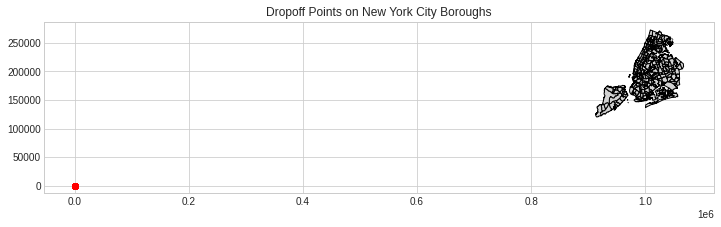

In [173]:
# Neighbourhoods to trip end locations
fig, ax = plt.subplots(figsize = (12,14))
df_2.plot(ax=ax, color='lightgrey', edgecolor='black') 
gdf_drop.plot(ax=ax, color='red') 
ax.set_title('Dropoff Points on New York City Boroughs')
plt.show()


6.2

In [174]:
gdf_pick = gpd.GeoDataFrame(
 df[['pickup_latitude', 'pickup_longitude']], geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude))


In [175]:
gdf_pick['count'] = 1

In [181]:
sum_hex = []
spatial_index = gdf_pick.sindex
for index, row in df_2.iterrows():
    polygon = row.geometry
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = gdf_pick.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.within(polygon)]
    sum_hex.append(sum(precise_matches['count']))

df_2['sum'] = sum_hex


In [176]:
!pip install Rtree
!pip install pygeos
!python -m pip install Django
!pip install geos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
!pip uninstall rtree
!sudo apt install libspatialindex-dev
!pip install rtreey


Found existing installation: Rtree 1.0.0
Uninstalling Rtree-1.0.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Rtree-1.0.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Rtree.libs/libspatialindex-91fc2909.so.6.1.1
    /usr/local/lib/python3.7/dist-packages/rtree/*
Proceed (y/n)? y
  Successfully uninstalled Rtree-1.0.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement rtreey (from versions: none)
ERROR: No matching distribution found for rtreey


In [178]:
!pip install geopandas
!pip uninstall rtree
!brew install spatialindex
!pip install rtree



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: brew: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Rtree-1.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)


In [179]:
import geopandas as gpd
import pygeos

In [180]:
import pygeos
from rtree import index
import django
from django.contrib.gis.geos import GEOSGeometry
from shapely.geometry import Point
from pygeos import points

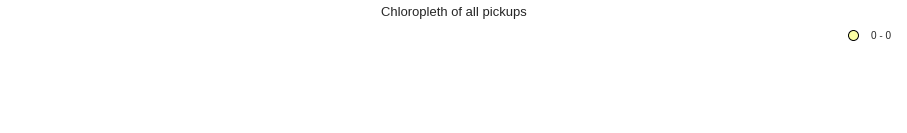

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# Set up the color sheme:
scheme = mc.Quantiles(df_2['sum'], k=10)
# Map
gplt.choropleth(df_2, hue="sum", linewidth=.1, scheme=scheme, cmap='inferno_r', legend=True, edgecolor='black', ax=ax);
ax.set_title('Chloropleth of all pickups', fontsize=13);

In [184]:
gdf_drop = gpd.GeoDataFrame(
 df[['dropoff_latitude', 'dropoff_longitude']], geometry=gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude))

In [185]:
gdf_drop['count'] = 1


In [186]:
# gdf_dropoff creating sum2 column in nyc shapefile from pickup locations sum2 = dropoff
sum_hex2 = []
spatial_index2 = gdf_drop.sindex
for index, row in df_2.iterrows():
 polygon2 = row.geometry
 possible_matches_index2 = list(spatial_index2.intersection(polygon2.bounds))
 possible_matches2 = gdf_drop.iloc[possible_matches_index2]
 precise_matches2 = possible_matches2[possible_matches2.within(polygon2)]
 sum_hex2.append(sum(precise_matches2['count']))
df_2['sum2'] = sum_hex2


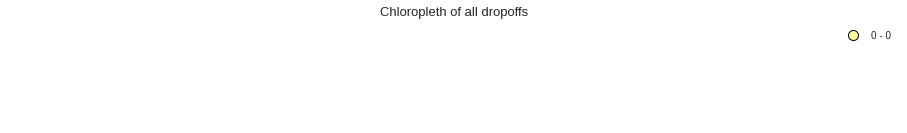

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# Set up the color sheme:
scheme2 = mc.Quantiles(df_2['sum2'], k=10)
# Map
gplt.choropleth(df_2, 
 hue="sum2", 
 linewidth=.1,
 scheme=scheme2, cmap='inferno_r',
 legend=True,
 edgecolor='black',
 ax=ax
);
ax.set_title('Chloropleth of all dropoffs', fontsize=13);


Within the boroughs, there is a greater spread of dropoffs than pickups.

Difference in distribution? between pickup and dropoff chloropeths?
There is a higher distribution of dropoffs than pickups within the boroughs


6.3

In [190]:
df_2['sum'].groupby(df_2['BoroName']).sum().reset_index().values

array([['Bronx', 0],
       ['Brooklyn', 0],
       ['Manhattan', 0],
       ['Queens', 0],
       ['Staten Island', 0]], dtype=object)

Manhattan has the most outgoing trips, followed by Queens

In [191]:
df_2['sum2'].groupby(df_2['BoroName']).sum().reset_index().values

array([['Bronx', 0],
       ['Brooklyn', 0],
       ['Manhattan', 0],
       ['Queens', 0],
       ['Staten Island', 0]], dtype=object)

Manhattan has the most incoming trips, followed by Brooklyn

6.4

In [192]:
night = df[(df.hour >= 0) & (df.hour <= 5)]

In [193]:
night_1 = gpd.GeoDataFrame(
 night[['pickup_latitude', 'pickup_longitude']], geometry=gpd.points_from_xy(night.pickup_longitude, night.pickup_latitude))
night_2 = gpd.GeoDataFrame(
 night[['dropoff_latitude', 'dropoff_longitude']], geometry=gpd.points_from_xy(night.dropoff_longitude, night.dropoff_latitude))
gdf_night = pd.concat([night_1, night_2])

In [194]:
gdf_night['count'] = 1


In [195]:
sum_hex3 = []
spatial_index3 = gdf_night.sindex
for index, row in df_2.iterrows():
    polygon3 = row.geometry
    possible_matches_index3 = list(spatial_index3.intersection(polygon3.bounds))
    possible_matches3 = gdf_night.iloc[possible_matches_index3]
    precise_matches3 = possible_matches3[possible_matches3.within(polygon3)]
    sum_hex3.append(sum(precise_matches3['count']))
df_2['sum3'] = sum_hex3


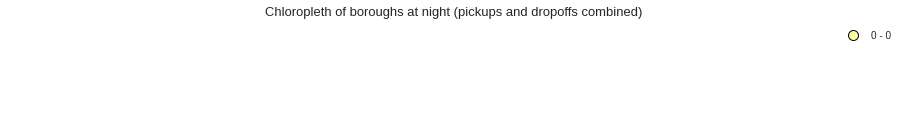

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# Set up the color sheme:
scheme3 = mc.Quantiles(df_2['sum3'], k=10)
# Map
gplt.choropleth(df_2, 
     hue="sum3", 
     linewidth=.1,
     scheme=scheme3, cmap='inferno_r',
     legend=True,
     edgecolor='black',
     ax=ax
);
ax.set_title('Chloropleth of boroughs at night (pickups and dropoffs combined)', fontsize=13);

In [198]:
df_2['sum3'].groupby(df_2['BoroName']).sum().reset_index().values

array([['Bronx', 0],
       ['Brooklyn', 0],
       ['Manhattan', 0],
       ['Queens', 0],
       ['Staten Island', 0]], dtype=object)

Manhattan is the busiest at night, followed by Brooklyn

Staten Island is the the quitest at night, followed by Bronx
